In [ ]:
pip install tensorflow opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 589.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense, Conv2D, Input, Flatten, Dropout,
                                     MaxPooling2D, BatchNormalization, GlobalAveragePooling2D,
                                     LayerNormalization, Embedding, MultiHeadAttention, UpSampling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
dataset_path = "/content/drive/MyDrive/MRIDataset"
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")

width, height = 224, 224
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    train_path,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode="categorical"
)

test_dataset = test_datagen.flow_from_directory(
    test_path,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


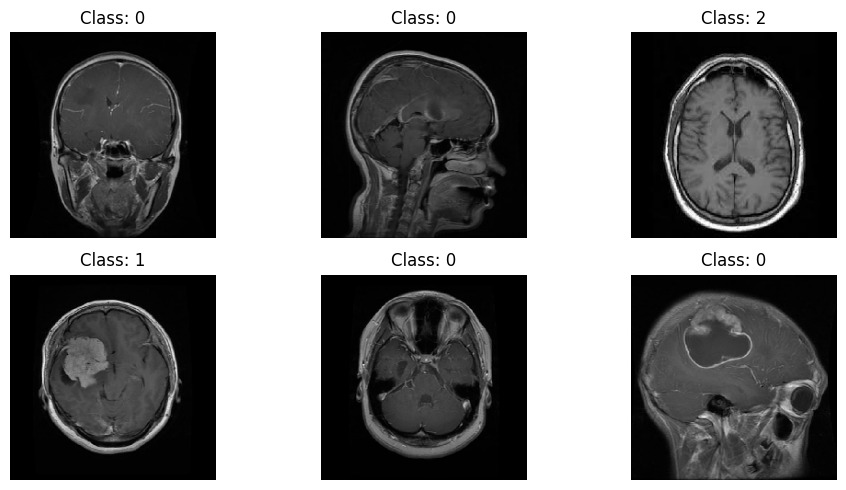

In [ ]:
x_batch, y_batch = next(train_dataset)
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Class: {np.argmax(y_batch[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
class PatchExtractor(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
           images=images,
           sizes=[1, self.patch_size, self.patch_size, 1],
           strides=[1, self.patch_size, self.patch_size, 1],
           rates=[1, 1, 1, 1],
           padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
# Layer to encode patches by projecting them and adding positional embeddings.
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

In [ ]:
# Transformer block
def transformer_block(inputs, num_heads, projection_dim, dropout_rate=0.1):
    # Normalization and Multi-head Self-Attention.
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x, x)
    x = tf.keras.layers.Add()([attention_output, inputs])
    # Feed Forward Network.
    x1 = LayerNormalization(epsilon=1e-6)(x)
    x1 = Dense(units=projection_dim * 2, activation='relu')(x1)
    x1 = Dense(units=projection_dim)(x1)
    x = tf.keras.layers.Add()([x, x1])
    return x

In [ ]:
def build_vit_classifier(input_shape=(width, height, 3), patch_size=32,
                         num_layers=8, num_heads=4, projection_dim=64,
                         mlp_head_units=[128]):
    inputs = Input(shape=input_shape)
    # Extract patches.
    patch_extractor = PatchExtractor(patch_size)
    patches = patch_extractor(inputs)
    # Determine number of patches.
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    # Encode patches.
    patch_encoder = PatchEncoder(num_patches, projection_dim)
    encoded_patches = patch_encoder(patches)

    # Apply Transformer blocks.
    for _ in range(num_layers):
        encoded_patches = transformer_block(encoded_patches, num_heads, projection_dim)

    # Create classification head.
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    for units in mlp_head_units:
        representation = Dense(units, activation='relu')(representation)
        representation = Dropout(0.1)(representation)
    outputs = Dense(4, activation='softmax')(representation)

    model = Model(inputs=inputs, outputs=outputs, name="ViT_Classifier")
    return model

In [ ]:
def build_efficientnet_classifier(input_shape=(width, height, 3), num_classes=4):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs, name="EfficientNet_Classifier")
    return model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.filters import threshold_otsu
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
def create_segmentation_mask(image):
    image_uint8 = (image * 255).astype(np.uint8)
    if image_uint8.shape[-1] == 3:
        gray = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_uint8
    thresh = threshold_otsu(gray)
    mask = gray > thresh
    return mask.astype(np.float32)

def segmentation_generator(image_generator):
    while True:
        images, _ = next(image_generator)
        masks = np.array([create_segmentation_mask(img) for img in images])
        masks = np.expand_dims(masks, axis=-1)
        yield images, masks

def build_unet_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    u4 = UpSampling2D((2, 2))(c3)
    u4 = Conv2D(32, (2, 2), activation='relu', padding='same')(u4)
    m4 = Concatenate()([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(m4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(c4)
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Conv2D(16, (2, 2), activation='relu', padding='same')(u5)
    m5 = Concatenate()([u5, c1])
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(m5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(c5)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs=inputs, outputs=outputs, name="Fast_U_Net")
    return model


In [ ]:
# Build models
vit_model  = build_vit_classifier()
eff_model  = build_efficientnet_classifier()
unet_model = build_unet_model()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile classification models
vit_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
eff_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
unet_model = build_unet_model()
unet_model.summary()

Model: "Fast_U_Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 224, 224, 16)   │            448 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 224, 224, 16)   │              0 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 224, 224, 16)   │          2,320 │ dropout_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 112, 112, 16)   │              0 │ conv2d_14[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 112, 112, 32)   │          4,640 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 112, 112, 32)   │              0 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 56, 56, 32)     │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 56, 56, 64)     │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 56, 56, 64)     │              0 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 112, 112, 64)   │              0 │ conv2d_18[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 112, 112, 32)   │          8,224 │ up_sampling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 112, 112, 64)   │              0 │ conv2d_19[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 112, 112, 32)   │         18,464 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 112, 112, 32)   │              0 │ conv2d_20[0][0]        │
├──────────────────────

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, restore_best_weights=True)

In [ ]:
# Train the ViT classifier
history_vit = vit_model.fit(
    train_dataset,
    steps_per_epoch=10,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=10,
    callbacks=[earlyStopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 198s 19s/step - accuracy: 0.3652 - loss: 1.6554 - val_accuracy: 0.3906 - val_loss: 1.3604
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 110s 12s/step - accuracy: 0.4374 - loss: 1.1624 - val_accuracy: 0.4875 - val_loss: 1.1238
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 93s 10s/step - accuracy: 0.5058 - loss: 1.1286 - val_accuracy: 0.6469 - val_loss: 0.9309
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - accuracy: 0.6169 - loss: 0.8965 - val_accuracy: 0.6062 - val_loss: 0.9452
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.6785 - loss: 0.7870 - val_accuracy: 0.6344 - val_loss: 0.9086
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.6839 - loss: 0.8060 - val_accuracy: 0.6969 - val_loss: 0.8119
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.7329 - loss: 0.6889 - val_accuracy: 0.6750 - val_loss: 0.8218
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.7438 - loss: 0.6691 - val_accuracy: 0.7063 - val_

In [ ]:
# Train the EfficientNet classifier
history_eff = eff_model.fit(
    train_dataset,
    steps_per_epoch=10,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=10,
    callbacks=[earlyStopping]
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 98s 9s/step - accuracy: 0.2518 - loss: 1.4073 - val_accuracy: 0.3313 - val_loss: 1.3852
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 74s 8s/step - accuracy: 0.2925 - loss: 1.4057 - val_accuracy: 0.3156 - val_loss: 1.3860
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - accuracy: 0.2590 - loss: 1.4312 - val_accuracy: 0.3625 - val_loss: 1.3628
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - accuracy: 0.3281 - loss: 1.3552 - val_accuracy: 0.2937 - val_loss: 1.3912
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - accuracy: 0.3076 - loss: 1.3765 - val_accuracy: 0.3219 - val_loss: 1.3679
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - accuracy: 0.3100 - loss: 1.3650 - val_accuracy: 0.2969 - val_loss: 1.3933


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 149s 15s/step - accuracy: 0.5692 - loss: 0.6974 - val_accuracy: 0.5642 - val_loss: 0.6941
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 147s 15s/step - accuracy: 0.7040 - loss: 0.6915 - val_accuracy: 0.8042 - val_loss: 0.6877
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 15s/step - accuracy: 0.7694 - loss: 0.6820 - val_accuracy: 0.7376 - val_loss: 0.6734
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 14s/step - accuracy: 0.6910 - loss: 0.6572 - val_accuracy: 0.7056 - val_loss: 0.6255
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 15s/step - accuracy: 0.6896 - loss: 0.6090 - val_accuracy: 0.7695 - val_loss: 0.6011
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 15s/step - accuracy: 0.7760 - loss: 0.5995 - val_accuracy: 0.8257 - val_loss: 0.5716
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 142s 14s/step - accuracy: 0.8289 - loss: 0.5715 - val_accuracy: 0.8658 - val_loss: 0.5329
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 142s 14s/step - accuracy: 0.8749 - loss: 0.5136 - val_accuracy: 0.

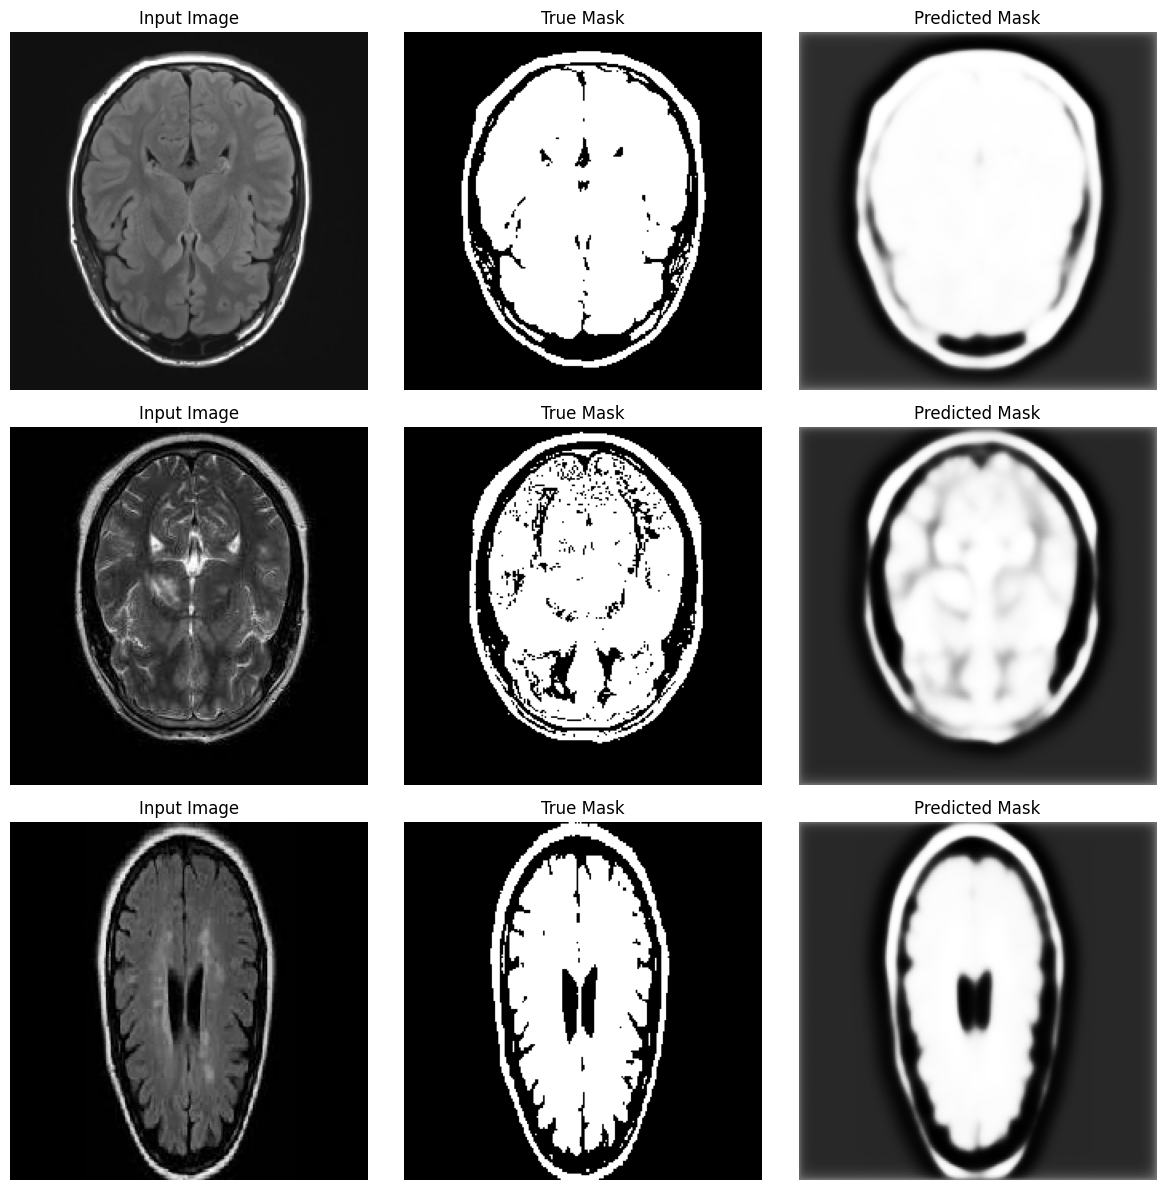

In [ ]:
train_segmentation_generator = segmentation_generator(train_dataset)
val_segmentation_generator = segmentation_generator(test_dataset)

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, restore_best_weights=True)
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
history_unet = unet_model.fit(train_segmentation_generator, steps_per_epoch=10, epochs=10, validation_data=val_segmentation_generator, validation_steps=10, callbacks=[earlyStopping])

x_seg, y_seg = next(val_segmentation_generator)
pred_masks = unet_model.predict(x_seg)
n = 3
plt.figure(figsize=(12, 4 * n))
for i in range(n):
    plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(x_seg[i])
    plt.title("Input Image")
    plt.axis("off")
    plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(y_seg[i].squeeze(), cmap="gray")
    plt.title("True Mask")
    plt.axis("off")
    plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(pred_masks[i].squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")
plt.tight_layout()
plt.show()

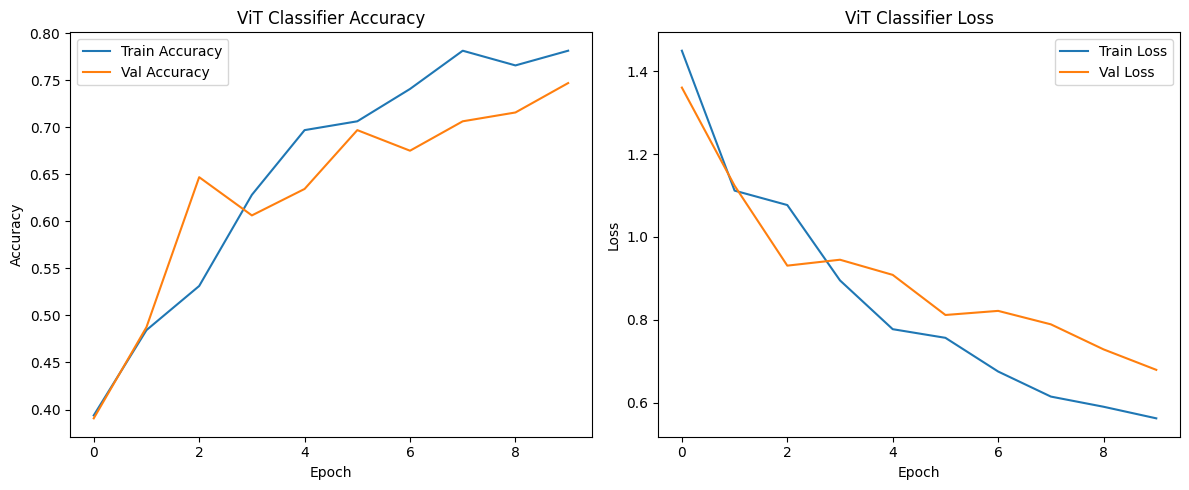

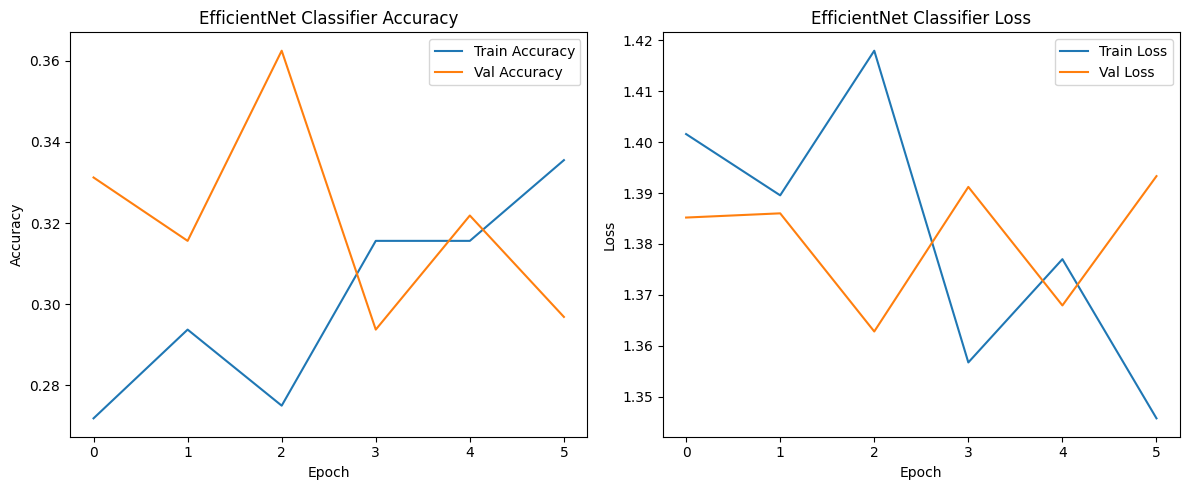

In [ ]:
# Function to plot training history
def plot_history(history, title_prefix="Model"):
    plt.figure(figsize=(12, 5))
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot history for ViT and EfficientNet
plot_history(history_vit, title_prefix="ViT Classifier")
plot_history(history_eff, title_prefix="EfficientNet Classifier")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


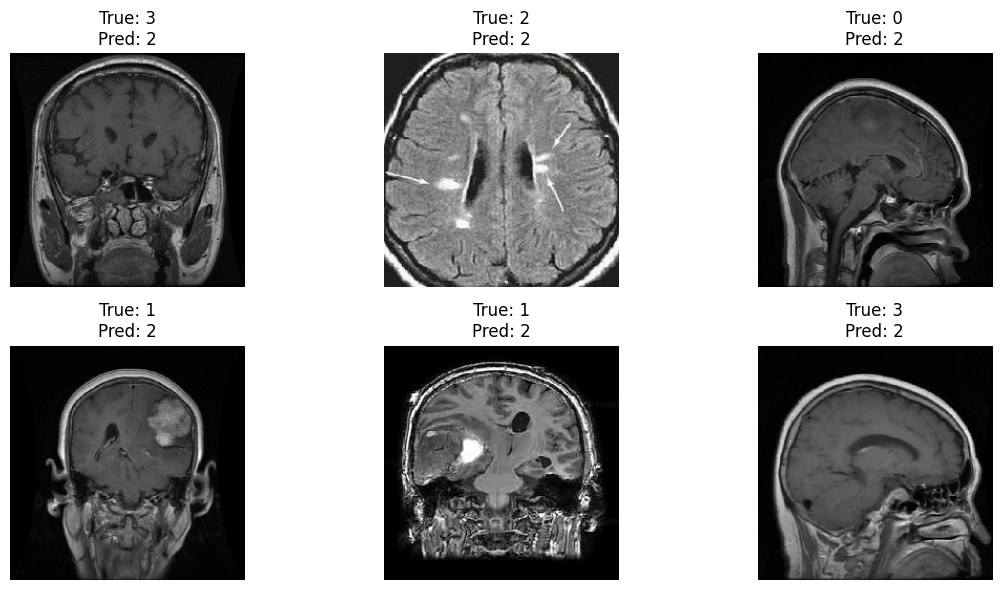

In [ ]:
# Visualize predictions on test images (using EfficientNet)
x_test, y_test = next(test_dataset)
preds_eff = eff_model.predict(x_test)
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_test[i])
    plt.title(f"True: {np.argmax(y_test[i])}\nPred: {np.argmax(preds_eff[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


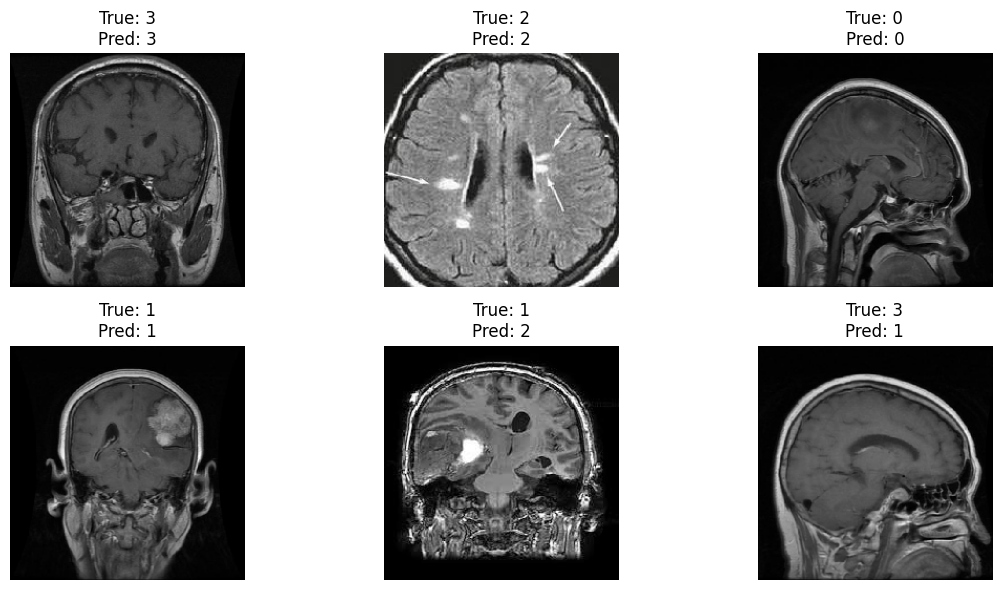

In [ ]:
# Similarly, you can visualize predictions from the ViT model:
preds_vit = vit_model.predict(x_test)
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_test[i])
    plt.title(f"True: {np.argmax(y_test[i])}\nPred: {np.argmax(preds_vit[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()